# scVI re-implementation on CORTEX dataset

**Paper (inspiration)**: Lopez, Romain, Jeffrey Regier, Michael B.Cole, Michael I. Jordan, and Nir Yosef. 2018. *Deep generative modeling for single-cell transcriptomics.* Nature Methods 15, no. 5 (December): 1053. https://doi.org/10.1038/s41592-018-0229-2.

## Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
%cd /content/drive/MyDrive/scvi_final_project_pgm/

[Errno 2] No such file or directory: '/content/drive/MyDrive/scvi_final_project_pgm/'
/content/drive/MyDrive/projet_PGM/scvi_final_project_pgm


In [4]:
import os
import torch
from torch.utils.data import DataLoader
import numpy as np

from src.data import load_cortex_rna_dataset
from src.models import SCVI
from src.training import fit
from src.distributions import elbo_scvi

## Dataset Loading

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
out_path = "data/cortex_rna.txt"

scRNA_cortex, gene_names, celltypes, labels, precise_labels  = load_cortex_rna_dataset(
    path=out_path,
    device=device
)

print("Number of cells:", len(scRNA_cortex))
print("Number of genes:", scRNA_cortex.X.shape[1])
print("Number of batches:", scRNA_cortex.n_batches)

Number of cells: 3005
Number of genes: 19972
Number of batches: 1


In [11]:
scVI_cortex_model = SCVI(
    n_genes = scRNA_cortex.X.shape[1],
    n_batches = scRNA_cortex.n_batches,
    mu_l_batch = scRNA_cortex.mu_l_batch,
    var_l_batch = scRNA_cortex.var_l_batch,
    latent_dim = 10
)

cortex_loader = DataLoader(scRNA_cortex, batch_size=128, shuffle=True)

## Model training

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history_scVI_cortex, best_state_scVI_cortex = fit(scVI_cortex_model, cortex_loader, elbo_scvi, epochs = 50, device = device)

Epoch 1/50 | loss: 18306.1762 | recon_x: 17827.0872 | kl_z: 169.4675 | kl_l: 309.6214
Epoch 2/50 | loss: 13676.9129 | recon_x: 13358.9540 | kl_z: 80.2677 | kl_l: 237.6913
Epoch 3/50 | loss: 12638.6127 | recon_x: 12256.6267 | kl_z: 65.1872 | kl_l: 316.7988
Epoch 4/50 | loss: 12691.6779 | recon_x: 11935.1935 | kl_z: 58.4154 | kl_l: 698.0690
Epoch 5/50 | loss: 12176.5218 | recon_x: 11799.6460 | kl_z: 48.6237 | kl_l: 328.2520
Epoch 6/50 | loss: 12023.1753 | recon_x: 11682.5186 | kl_z: 45.9896 | kl_l: 294.6673
Epoch 7/50 | loss: 11800.6703 | recon_x: 11517.2978 | kl_z: 42.3061 | kl_l: 241.0665
Epoch 8/50 | loss: 11693.9025 | recon_x: 11460.1340 | kl_z: 40.1623 | kl_l: 193.6064
Epoch 9/50 | loss: 11614.4777 | recon_x: 11414.3155 | kl_z: 38.3111 | kl_l: 161.8511
Epoch 10/50 | loss: 11611.1240 | recon_x: 11356.4534 | kl_z: 38.2910 | kl_l: 216.3795
Epoch 11/50 | loss: 11531.6021 | recon_x: 11321.3553 | kl_z: 36.0844 | kl_l: 174.1625
Epoch 12/50 | loss: 11477.8540 | recon_x: 11283.8784 | kl_z: 3

In [13]:
best_scVI_cortex_model = SCVI(
    n_genes = scRNA_cortex.X.shape[1],
    n_batches = scRNA_cortex.n_batches,
    mu_l_batch = scRNA_cortex.mu_l_batch,
    var_l_batch = scRNA_cortex.var_l_batch,
    latent_dim=10
).to("cuda")
best_scVI_cortex_model.load_state_dict(best_state_scVI_cortex)

<All keys matched successfully>

In [21]:
from src.utils import (
    summary_plot,
    predict_latents,
    get_tsne_embedding,
    tsne_cell_state_plot_with_labels
)

In [22]:
from src.utils import count_n_params

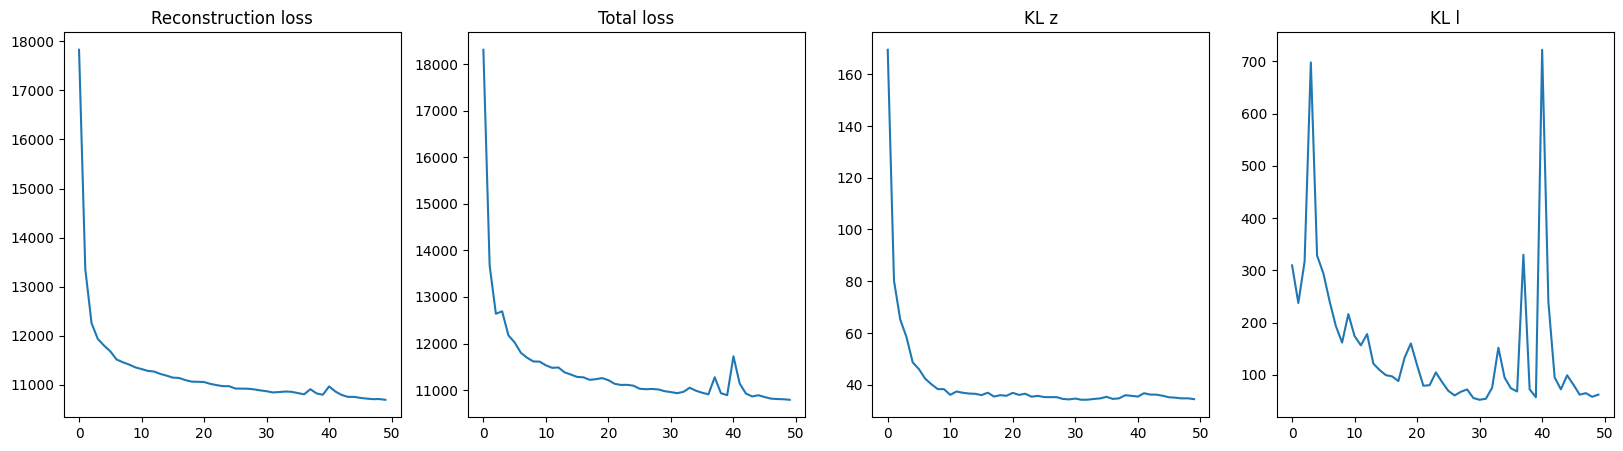

In [15]:
summary_plot(history_scVI_cortex)

In [23]:
count_n_params(best_scVI_cortex_model)

Model has 10343488 trainable parameters


## Inference

In [16]:
dataloader = DataLoader(scRNA_cortex, batch_size=128, shuffle=False)
scVI_rna_cortex_mu_z = predict_latents(best_scVI_cortex_model, dataloader)
z_cortex = get_tsne_embedding(scVI_rna_cortex_mu_z)

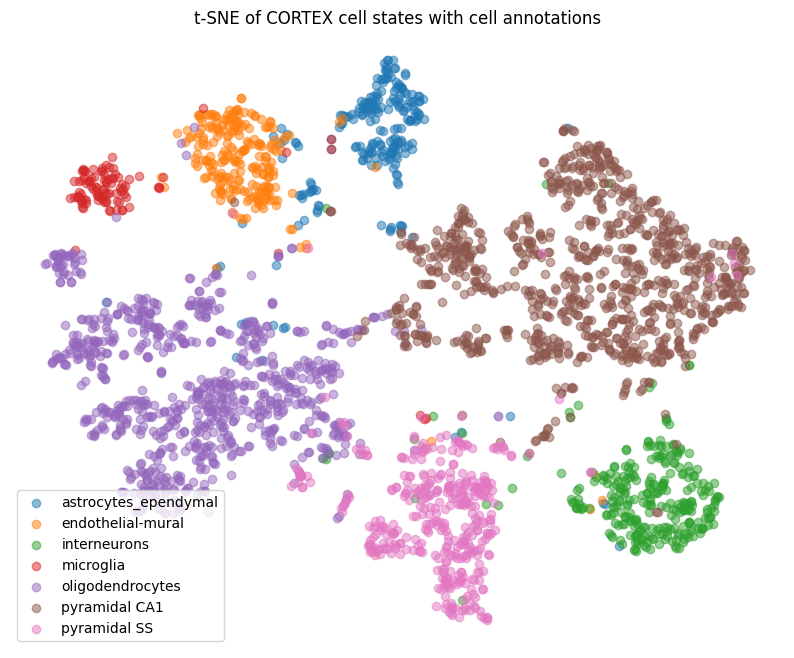

In [17]:
celltype_labels = [str(celltypes[idx]) for idx in labels]
tsne_cell_state_plot_with_labels(
    z_cortex,
    celltype_labels,
    title = "t-SNE of CORTEX cell states with cell annotations")

## Conclusions

- scVI can succesfully recover cell types in latent space
- With 10M parameters and a 10-dimensional latent space, this scVI model can differentiate between cortical cell types in just about 12 seconds of training.